# Calculate distances between specific residues in pdb files

In [1]:
from biopandas.pdb import PandasPdb
from os.path import exists
import numpy as np

PATH_XLS_INTRA_NONRED = 'XLs_intra_nonred.csv'

UNRELAXED_PDB_SUFFIX = '-unrelaxed_model_1.pdb'
RELAXED_PDB_SUFFIX = '-relaxed_model_1.pdb'
PTM_PDB_SUFFIX = '-relaxed_model_1_ptm.pdb'
RESULTS_PKL_SUFFIX = '-result_model_1_ptm.pkl'
PAE_PKL_SUFFIX = '-pae_model_1_ptm.pkl'

pdbs = {}


def sanitize_protein(protein_id):
    """Replace / in protein ID with _ for compatibility with file system"""
    return protein_id.replace("/", "_")


def calculate_dist(pdb, xl):
    """Calculate the distance between residues in the PDB based on the crosslink"""
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == xl.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == xl.Res2]

    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    return np.linalg.norm(res_1_coords - res_2_coords)


def read_pdb_ca(pdb_filepath):
    ppdb = PandasPdb().read_pdb(pdb_filepath)  # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM']  # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name'] == 'CA')]  # selects the only the CA atoms


def read_protein_pdb(protein, pdb_suffix):
    if pdb_suffix not in pdbs:
        pdbs[pdb_suffix] = {}
    elif protein in pdbs[pdb_suffix]:
        return pdbs[pdb_suffix][protein]
    pdbs_with_suffix = pdbs[pdb_suffix]

    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if not exists(pdb_filepath):
        # print(protein + ' PDB file not found. Skipping...')
        return None
    pdb_ca = read_pdb_ca(pdb_filepath)

    pdbs_with_suffix[protein] = pdb_ca
    return pdb_ca


def fill_xls_from_pdb(protein_name, threshold, pdb, xls):
    xls['af_distance'] = xls.apply(
        lambda x: x.af_distance if x.Protein1 != protein_name else calculate_dist(pdb, x), axis=1)
    return xls[(xls['af_distance'] < threshold) & (xls['Protein1'] == protein_name)]


In [2]:
import pandas as pd
import seaborn as sns
import json

In [3]:
if exists(PATH_XLS_INTRA_NONRED):
    XLs_intra_nonred = pd.read_csv(PATH_XLS_INTRA_NONRED)
else:
    # Read in XL csv file to pandas DF
    XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding='unicode_escape')

    # Save all intramolecular crosslinks to a new DF
    XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

    # Calculate the XL position in the protein primary sequence
    XLs_intra.loc[:, 'Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
    XLs_intra.loc[:, 'Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

    # Removes all XL redundancies
    XLs_intra.loc[:, 'newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
    XLs_intra.loc[:, 'newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
    XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

    # Save to file
    XLs_intra_nonred.to_csv(PATH_XLS_INTRA_NONRED)

In [4]:
# Extract XL counts
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(
    columns={'index': 'Protein1', 'Protein1': 'XL_count'})
XLs_intra_nonred.loc[:, 'af_distance'] = None
XLs_intra_nonred

Unnamed: 0     Id   Score     Protein1  PepPos1  \
0             13     14  413.29  RSPH4A/6A-2       86   
1             20     21  396.55         ILS1      935   
2             35     36  369.15       I7LU32      298   
3             70     71  338.56        CDC27      742   
4             75     76  335.56        IDP2       345   
...          ...    ...     ...          ...      ...   
3399       19421  19422  146.57        IFT52       40   
3400       19422  19423  155.26       IFT144      965   
3401       19424  19425  132.32         CCT5       46   
3402       19425  19426  155.99        IFT81      480   
3403       19426  19427   69.83       Q22NG6      132   

                              PepSeq1  LinkPos1     Protein2  PepPos2  \
0     KLLDPLMEGEEDNLAPVGAIGYVPNFMEEAK         1  RSPH4A/6A-2       72   
1                    EYNKDLKAAAGNLSAK         7         ILS1      921   
2                TQIHTSYGLNQHKEAISLFR        13       I7LU32      318   
3                          SQKEIEDQKK         3        CDC27      752   
4                      AKLDNNKELDLFCK         7        IDP2       408   
...                               ...       ...          ...      ...   
3399                        NKEDITYDR         2        IFT52       33   
3400                       LNLDKLDNLR         5       IFT144      935   
3401                       SSLGPKGMDK         6         CCT5      173   
3402                      NKTEYDQMLKK        10        IFT81      491   
3403                     KYFEYSQNLNIK         1       Q22NG6      133   

             PepSeq2  LinkPos2  Res1  Res2  newRes1  newRes2 af_distance  
0     EKYEAVSESFKANK        11    86    82       86       82        None  
1        AIPNHKLLGQK         6   941   926      941      926        None  
2            KVQGGQK         1   310   318      318      310        None  
3           KLDEELLR         1   744   752      752      744        None  
4         KNLVAAKSNL         7   351   414      414      351        None  
...              ...       ...   ...   ...      ...      ...         ...  
3399         ETYKCGR         4    41    36       41       36        None  
3400          QYAKAK         4   969   938      969      938        None  
3401         VVSKNKR         6    51   178      178       51        None  
3402           LEKEK         3   489   493      493      489        None  
3403    YFEYSQNLNIKK        11   132   143      143      132        None  

[3404 rows x 16 columns]

In [5]:
def get_af_xl_counts(protein_xl_counts, threshold, pdb_suffix):
    protein = protein_xl_counts['Protein1']
    pdb_ca = read_protein_pdb(protein, pdb_suffix)
    if pdb_ca is None:
        return None
    return fill_xls_from_pdb(protein, threshold, pdb_ca, XLs_intra_nonred).count()['Id']

In [6]:
intra_XL_counts['af_XL_count'] = intra_XL_counts.apply(lambda x: get_af_xl_counts(x, 40, UNRELAXED_PDB_SUFFIX), axis=1)

intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

Protein1  XL_count  af_XL_count
4        PRKG1        38         38.0
5         EEF2        35         30.0
6       MRNC57        34         27.0
9    EMAP5/6-1        30         30.0
10      I7MJ59        30         18.0
..         ...       ...          ...
120     I7LW80         8          8.0
121     I7LZI8         7          6.0
123     I7MEJ5         7          7.0
128     I7MHD4         7          7.0
138   CCDC81-1         7          6.0

[90 rows x 3 columns]

## Compare Confidence and XL Agreement

In [7]:
def read_confidence(intra_xl_counts):
    protein = intra_xl_counts['Protein1']

    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if not exists(ranking_filepath):
        #print(protein + ' ranking file not found. Skipping...')
        return None

    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        return ranking_debug['plddts']['model_1']


intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x: read_confidence(x), axis=1)

In [8]:
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

Protein1  XL_count  af_XL_count  confidence  XL_agreement
4        PRKG1        38         38.0   78.041609      1.000000
5         EEF2        35         30.0   89.479929      0.857143
6       MRNC57        34         27.0   68.385990      0.794118
9    EMAP5/6-1        30         30.0         NaN      1.000000
10      I7MJ59        30         18.0   67.924191      0.600000
..         ...       ...          ...         ...           ...
120     I7LW80         8          8.0   68.536852      1.000000
121     I7LZI8         7          6.0   97.085454      0.857143
123     I7MEJ5         7          7.0   80.420044      1.000000
128     I7MHD4         7          7.0   95.693012      1.000000
138   CCDC81-1         7          6.0   68.906479      0.857143

[90 rows x 5 columns]

<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

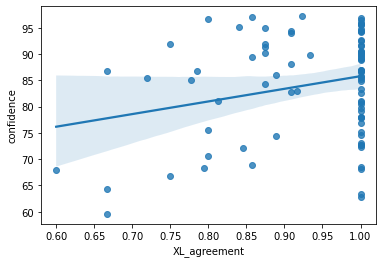

In [9]:
sns.regplot(x=intra_XL_counts['XL_agreement'], y=intra_XL_counts['confidence'])

In [10]:
XLs_intra_nonred[XLs_intra_nonred['af_distance'].notnull()]

Unnamed: 0     Id   Score Protein1  PepPos1                    PepSeq1  \
1             20     21  396.55     ILS1      935           EYNKDLKAAAGNLSAK   
3             70     71  338.56    CDC27      742                 SQKEIEDQKK   
5            110    111  324.58   I7LUZ1      315  VICILDKPIPGTKDIPSVQIIIPQR   
8            247    248  299.14   Q234E6      487           AQVVEQSLEKHIQNEK   
12           327    328  288.74     PGM1       37        VSVVKEAHYLENFVSSVFK   
...          ...    ...     ...      ...      ...                        ...   
3349       19345  19346  138.44   IFT172      556               QLYLYNIKTQTK   
3355       19355  19356  119.83   IFT172      206      SNKSQVMYSTDSYVVSLAACK   
3370       19378  19379   84.75      DLD       43              AGQLGLKTACVEK   
3383       19400  19401  132.50      DLD      127                NKVDYFVGTGR   
3398       19420  19421   94.69   IFT172     1174                   MAQKAIHK   

      LinkPos1 Protein2  PepPos2              PepSeq2  LinkPos2  Res1  Res2  \
1            7     ILS1      921          AIPNHKLLGQK         6   941   926   
3            3    CDC27      752             KLDEELLR         1   744   752   
5           13   I7LUZ1      128  VPANDKEALQSDLMGLLEK         6   327   133   
8           10   Q234E6      603             SKAGTVTR         2   496   604   
12           5     PGM1       76         YFNKEAIDIIIK         4    41    79   
...        ...      ...      ...                  ...       ...   ...   ...   
3349         8   IFT172      496           LNYHSVKQTK         7   563   502   
3355         3   IFT172      199              VKSGILR         2   208   200   
3370         7      DLD      127          NKVDYFVGTGR         2    49   128   
3383         2      DLD      119             GIESLFKK         7   128   125   
3398         4   IFT172     1182              KPDVHLK         1  1177  1182   

      newRes1  newRes2  af_distance  
1         941      926    11.486842  
3         752      744    11.888002  
5         327      133    17.507300  
8         604      496    18.352268  
12         79       41    12.467422  
...       ...      ...          ...  
3349      563      502    15.064587  
3355      208      200    10.165514  
3370      128       49     7.841158  
3383      128      125     4.894888  
3398     1182     1177     9.079290  

[1134 rows x 16 columns]

In [11]:
# Determine XL agreement percentage

af_xls = XLs_intra_nonred[XLs_intra_nonred['af_distance'].notnull()]
print('% XL Agreement: {}'.format((af_xls['af_distance'] <= 30).mean() * 100))

% XL Agreement: 86.24338624338624


## Compare Unrelaxed vs Relaxed XL counts for top 10 most crosslinked proteins

In [12]:
intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(lambda x: get_af_xl_counts(x, 40, RELAXED_PDB_SUFFIX),
                                                               axis=1)
intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_XL_count']
intra_XL_counts[intra_XL_counts['af_relaxed_XL_count'].notnull()]

Protein1  XL_count  af_XL_count  confidence  XL_agreement  \
4       PRKG1        38         38.0   78.041609      1.000000   
5        EEF2        35         30.0   89.479929      0.857143   
6      MRNC57        34         27.0   68.385990      0.794118   
9   EMAP5/6-1        30         30.0         NaN      1.000000   
10     I7MJ59        30         18.0   67.924191      0.600000   
11     BBC118        25         18.0   85.481704      0.720000   
12      FTT18        25         21.0   95.138586      0.840000   
13       EARS        24         24.0   91.715565      1.000000   
14  EMAP5/6-2        22         22.0         NaN      1.000000   
16     Q23A15        20         16.0   75.527561      0.800000   

    af_relaxed_XL_count  relaxed_XL_agreement  relaxed_vs_unrelaxed_diff  
4                  38.0              1.000000                        0.0  
5                  30.0              0.857143                        0.0  
6                  26.0              0.764706                       -1.0  
9                  30.0              1.000000                        0.0  
10                 20.0              0.666667                        2.0  
11                 18.0              0.720000                        0.0  
12                 21.0              0.840000                        0.0  
13                 24.0              1.000000                        0.0  
14                 22.0              1.000000                        0.0  
16                 15.0              0.750000                       -1.0

## Examine PAE pattern in protein PRKG1 and EEF2 to see how to extract domains

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import SpectralClustering
from scipy import ndimage as ndi
from skimage.morphology import square
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte


def plot_plddt(protein):
    sanitized_protein = sanitize_protein(protein)
    results = pd.read_pickle('results/' + sanitized_protein + RESULTS_PKL_SUFFIX)

    plddt = results['plddt']

    plt.figure(figsize=[16, 6])
    plt.subplot(1, 2, 1)
    plt.plot(plddt)
    plt.title('Predicted LDDT')
    plt.xlabel('Residue')
    plt.ylabel('pLDDT')


def display_clusters(labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    clusters_df = pd.DataFrame([[a if a == b else 0 for b in labels] for a in labels])
    plt.imshow(clusters_df)
    plt.colorbar(fraction=0.046, pad=0.04)


def predict_and_display_clusters(pae, n_clusters):
    # predicted = KMeans(n_clusters=n_clusters).fit(pae)

    affinity = np.exp(- pae ** 2 / (2. * 1 ** 2))
    predicted = SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(affinity)

    display_clusters(predicted.labels_)


def plot_pae(protein, xl_thresholds, n_clusters):
    sanitized_protein = sanitize_protein(protein)

    results = pd.read_pickle('pae/' + sanitized_protein + PAE_PKL_SUFFIX)

    pae = results['predicted_aligned_error']
    max_pae = results['max_predicted_aligned_error']

    protein_xls = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein]

    figure = plt.figure(figsize=(15, 15))
    figure.patch.set_facecolor('white')
    subplot_index = 1

    for xl_threshold in xl_thresholds:
        plt.subplot(1, len(xl_thresholds) + 1, subplot_index)
        subplot_index += 1

        protein_xls_agreed = protein_xls[protein_xls['af_distance'] <= xl_threshold]
        protein_xls_missed = protein_xls[protein_xls['af_distance'] > xl_threshold]

        # plt.subplot(1, 2, 2)
        plt.imshow(pae, norm=colors.Normalize(vmin=0, vmax=max_pae), cmap='YlGn_r', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.scatter(protein_xls_agreed['newRes1'], protein_xls_agreed['newRes2'], marker='o', facecolor='none',
                    edgecolor='blue')
        plt.scatter(protein_xls_missed['newRes1'], protein_xls_missed['newRes2'], marker='x', c='purple')

        plt.title(protein + ' Predicted Aligned Error, XL Threshold ' + str(xl_threshold))
        plt.xlabel('Scored residue')
        plt.ylabel('Aligned residue')

    plt.subplot(1, len(xl_thresholds) + 1, subplot_index)

    predict_and_display_clusters(pae, n_clusters)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 5
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 4
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 6
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 3
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 2
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 4
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 5
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 4
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 5
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 4
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 3
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 6
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 4
Estimated number of noise points: 0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Estimated number of clusters: 3
Estimated number of noise points: 0


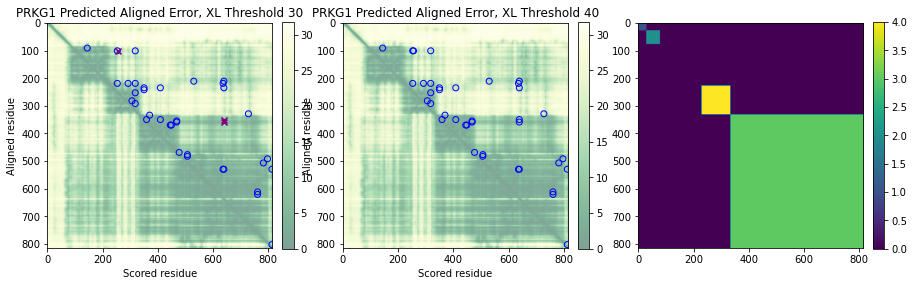

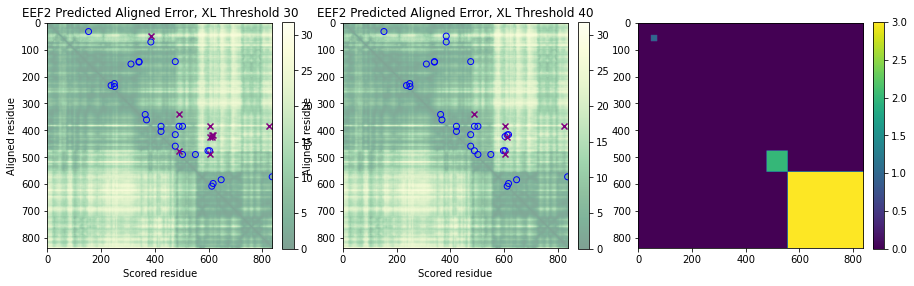

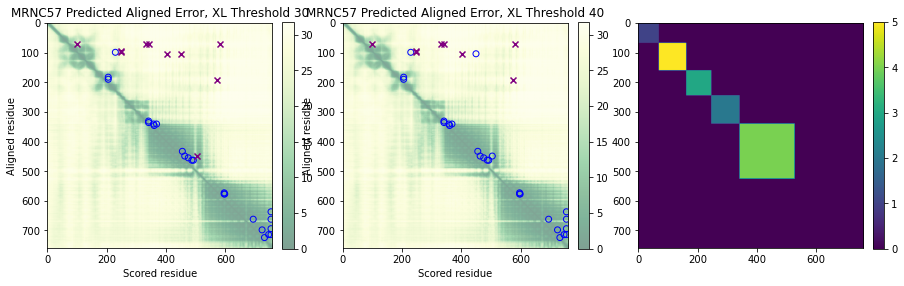

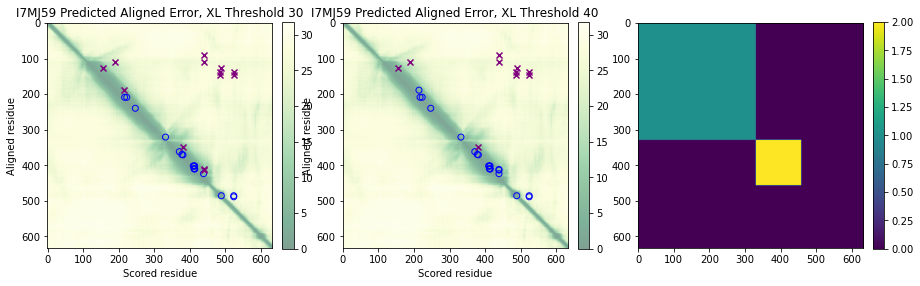

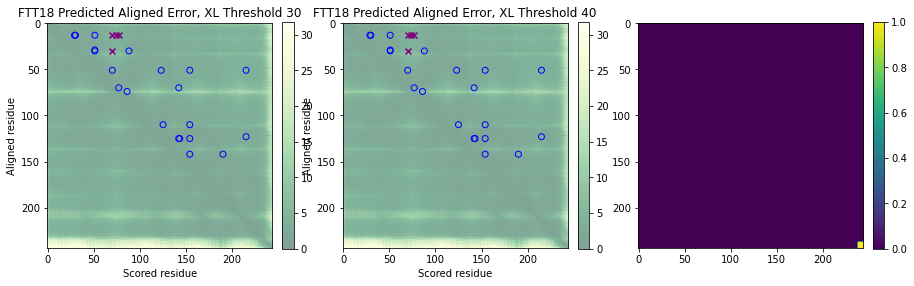

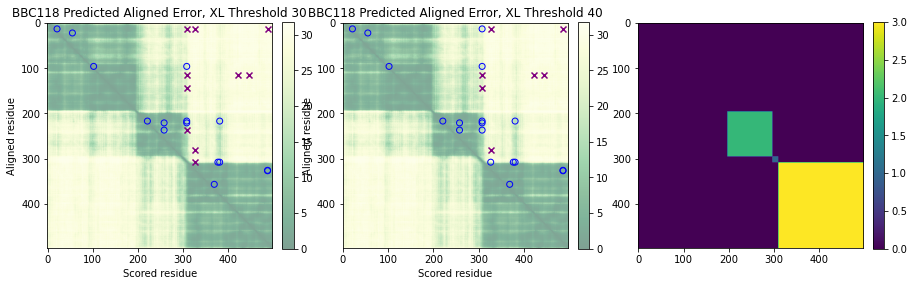

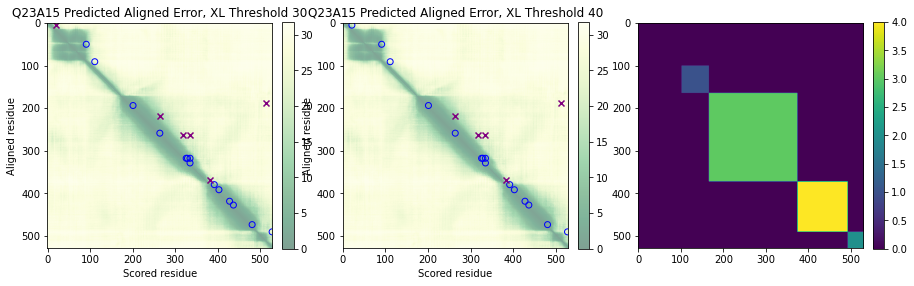

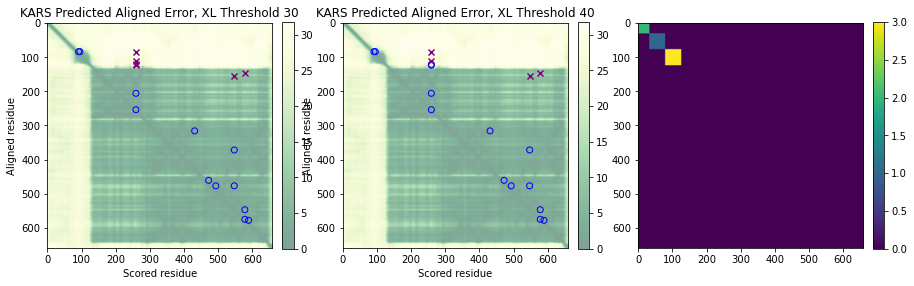

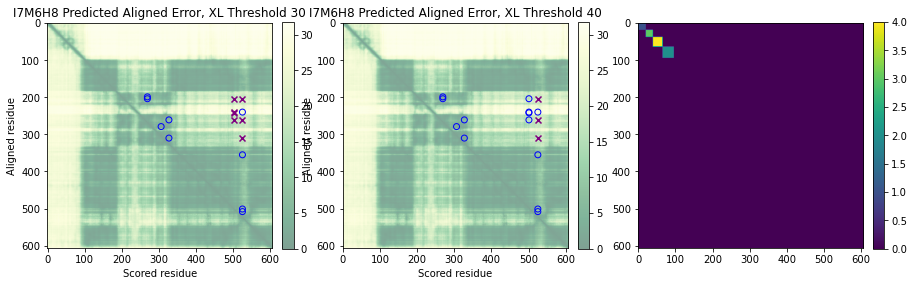

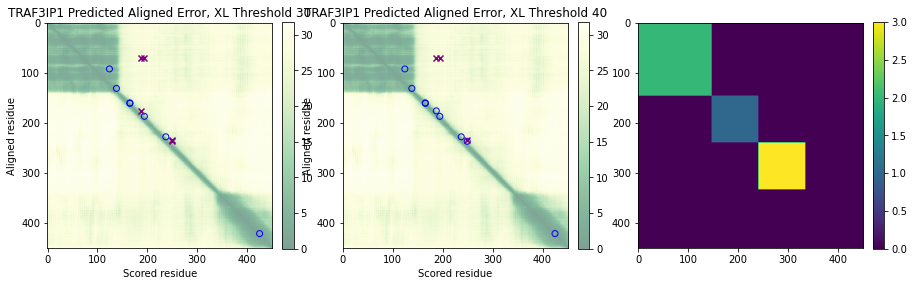

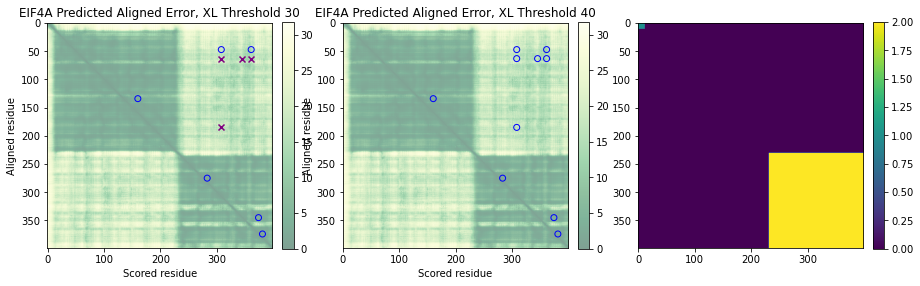

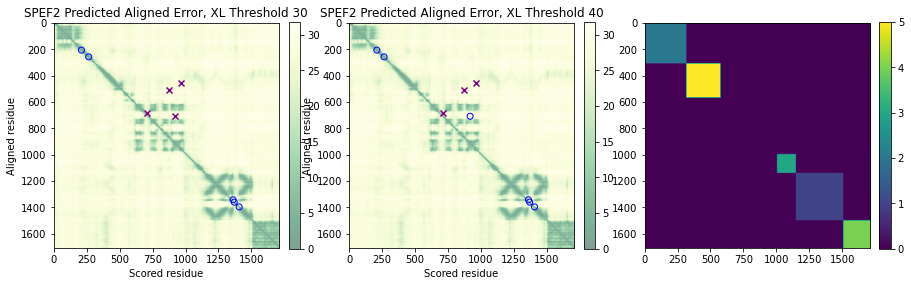

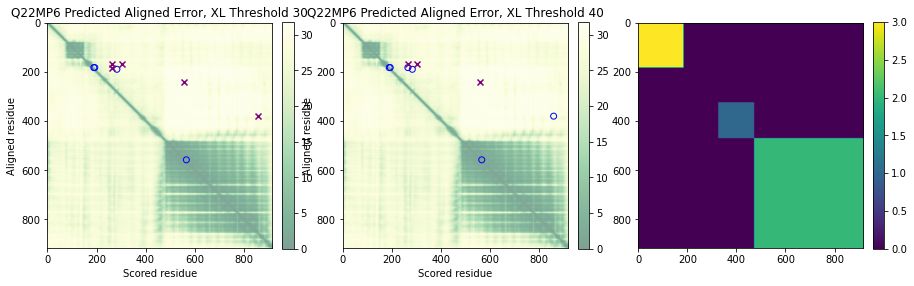

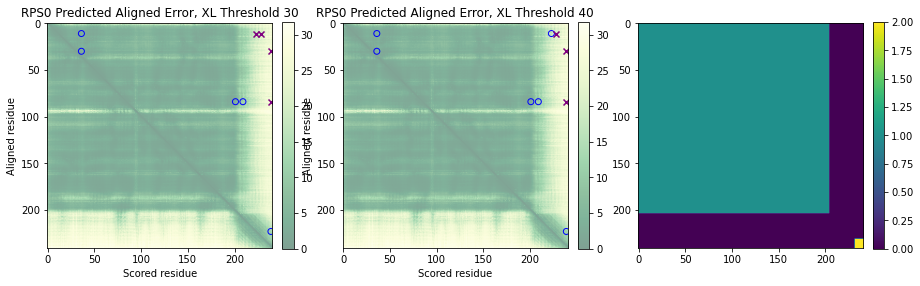

In [16]:
pae_proteins_n_clusters = [
    ("PRKG1", 5),
    ("EEF2", 4),
    ("MRNC57", 6),
    ("I7MJ59", 3),
    ("FTT18", 2),
    ("BBC118", 4),
    ("Q23A15", 5),
    ("KARS", 4),
    ("I7M6H8", 5),
    ("TRAF3IP1", 4),
    ("EIF4A", 3),
    ("SPEF2", 6),
    ("Q22MP6", 4),
    ("RPS0", 3),
]
thresholds = [30, 40]

for pae_protein_n_clusters in pae_proteins_n_clusters:
    pae_protein = pae_protein_n_clusters[0]
    n_clusters = pae_protein_n_clusters[1]
    plot_pae(pae_protein, thresholds, n_clusters)

In [61]:
from collections import Counter


def make_symmetric(pae):
    pae = np.array(pae)
    return (pae + pae.transpose()) / 2

def predict_watershed(name, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise):
    pae = make_symmetric(pae)

    img_pae = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))
    image = img_as_ubyte(img_pae)

    # denoise image
    denoised = rank.median(image, square(denoise_footprint))

    if repeat_denoise > 1:
        for i in range(0, repeat_denoise):
            denoised = rank.median(denoised, square(denoise_footprint))

    # find continuous region (low gradient -
    # where less than marker_threshold for this image) --> markers
    # square(marker_footprint) is used here to get a more smooth image
    markers = rank.gradient(denoised, square(marker_footprint)) < marker_threshold
    markers = ndi.label(markers)[0]

    # local gradient (square(gradient_footprint) is used to keep edges thin)
    gradient = rank.gradient(denoised, square(gradient_footprint))

    # process the watershed
    labels = watershed(gradient, markers)

    diagonal = np.diagonal(np.array(labels))
    domain_labels = diagonal.copy()
    domain_edge_threshold = 40
    for i in range(0, len(domain_labels)):
        label = domain_labels[i]
        before = 0
        after = 0
        if i >= domain_edge_threshold:
            before = labels[i, i - domain_edge_threshold]
        if i + domain_edge_threshold < domain_labels.shape[0]:
            after = labels[i, i + domain_edge_threshold]
        if before != label and after != label:
            domain_labels[i] = 0

    domains_count = np.bincount(domain_labels)
    domain_count_threshold = 30
    segment_background_labels = []
    # If there are "background" non-domain labels, mark as 0
    if len(domains_count) > 1:
        segment_background_labels.append(labels[0, len(domain_labels) - 1])
        segment_background_labels.append(labels[len(domain_labels) - 1, 0])
    for i in range(0, len(domain_labels)):
        if domain_labels[i] in segment_background_labels:
            domain_labels[i] = 0
        if domains_count[domain_labels[i]] < domain_count_threshold:
            domain_labels[i] = 0

    # Fill empty gaps in labeled regions
    domains_counter = Counter(domain_labels)
    fill_label = None
    for i in range(0, len(domain_labels)):
        if domain_labels[i] != 0:
            # Determine region label and count down to end of region
            fill_label = domain_labels[i]
            domains_counter[fill_label] = domains_counter[fill_label] - 1
            if domains_counter[fill_label] == 0:
                fill_label = None
        elif fill_label is not None:
            # Fill in 0s with label
            domain_labels[i] = fill_label


    domains_mat = np.array([i if i == j else 0 for i in domain_labels for j in domain_labels]).reshape(domain_labels.shape[0], domain_labels.shape[0])

    # display results
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(21, 4),
                             sharex=True, sharey=True)
    fig.patch.set_facecolor('white')
    fig.suptitle(name + ' Watershed Segmentation')

    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("Original")

    ax[1].imshow(denoised, cmap=plt.cm.gray)
    ax[1].set_title("Denoised")

    ax[2].imshow(gradient, cmap=plt.cm.nipy_spectral)
    ax[2].set_title("Local Gradient")

    ax[3].imshow(markers)
    ax[3].set_title("Markers")

    ax[4].imshow(labels)
    ax[4].set_title("Segmented")

    ax[5].imshow(domains_mat)
    ax[5].set_title("Domains")

    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='black')

    domains_mat = np.ma.masked_where(domains_mat == 0, domains_mat)
    ax[6].imshow(domains_mat,  cmap=cmap, alpha = 1 - img_pae)
    ax[6].set_title("Domains Overlayed")

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

    print(np.unique(labels), 'labels')
    print(np.unique(domain_labels), 'domains')

    return labels


def predict_watershed_for_proteins(proteins_with_parameters):
    labels = []
    for pae_protein in proteins_with_parameters:
        (protein, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise) = pae_protein
        results = pd.read_pickle('pae/' + sanitize_protein(protein) + PAE_PKL_SUFFIX)
        pae = results['predicted_aligned_error']

        labels.append(predict_watershed(protein, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise))

    return labels


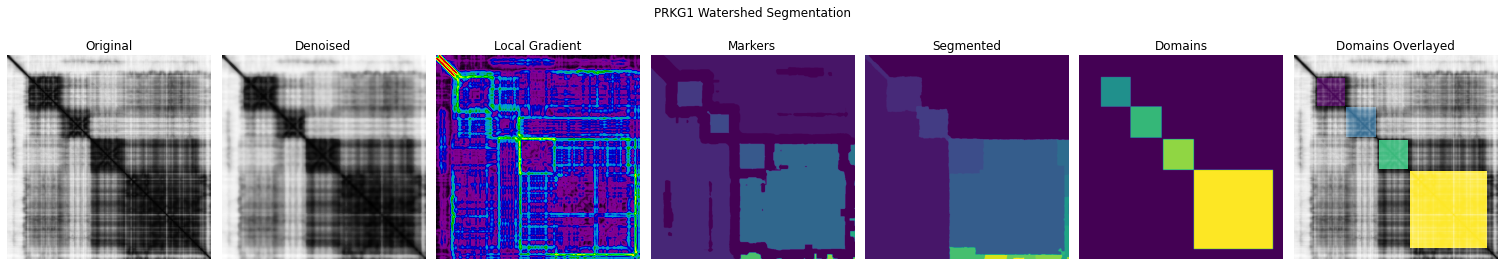

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] labels
[0 3 4 5 6] domains


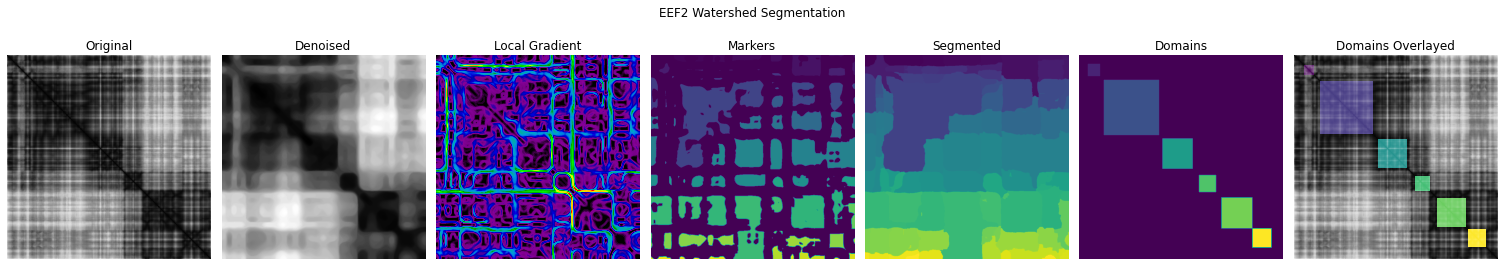

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122] labels
[  0  10  25  56  73  80 101] domains


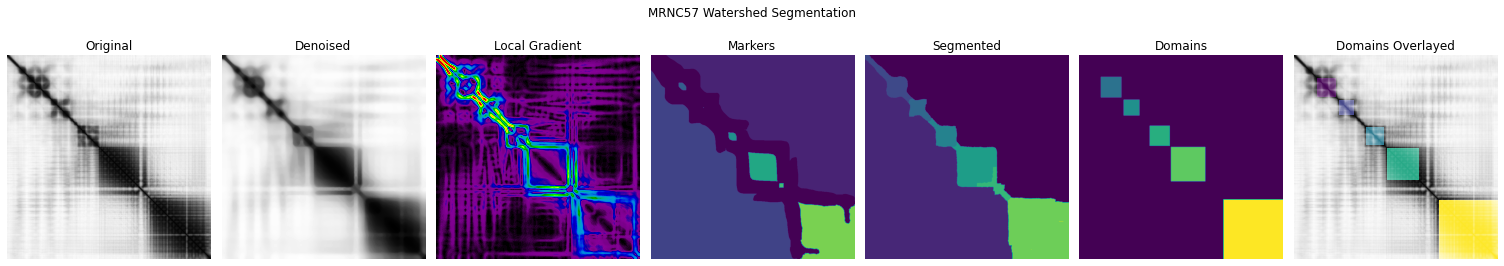

[ 1  2  3  4  5  6  7  8  9 10] labels
[0 3 4 5 6 8] domains


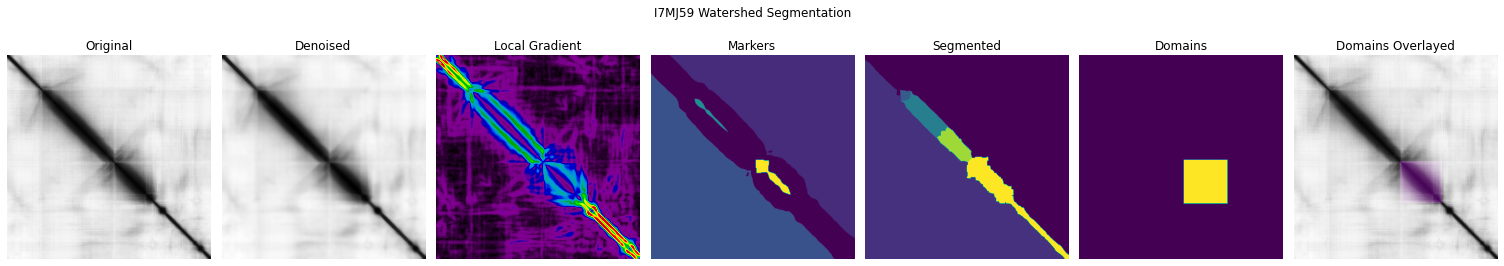

[1 2 3 4 5 6 7 8] labels
[0 8] domains


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


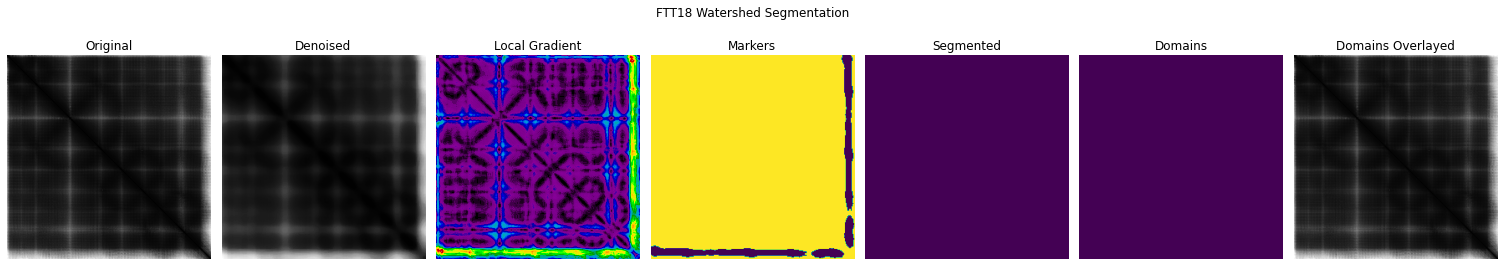

[1] labels
[0] domains


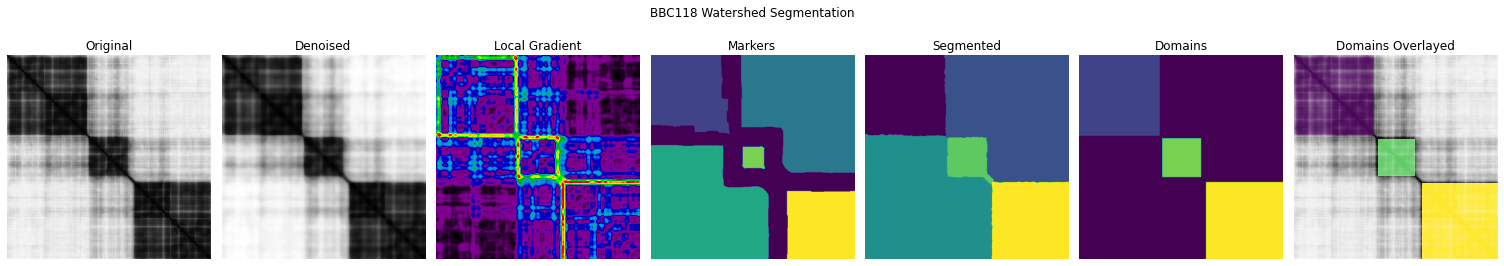

[1 2 3 4 5] labels
[0 1 4 5] domains


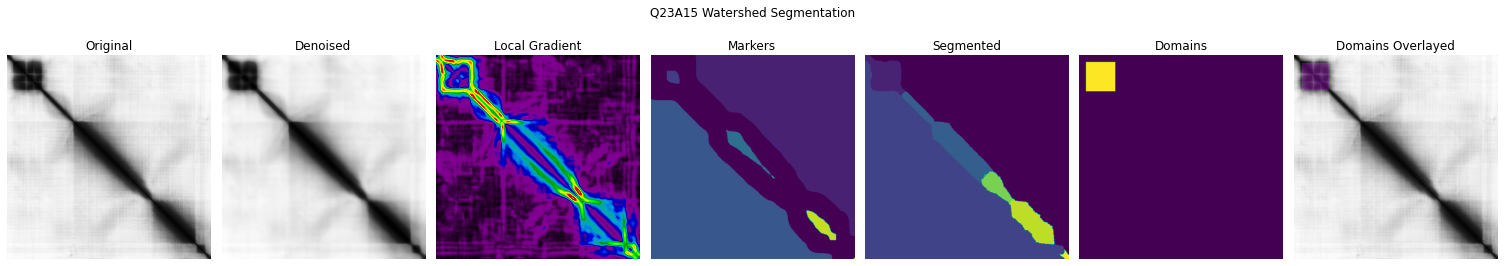

[ 1  2  3  4  5  6  7  8  9 10 11] labels
[0 2] domains


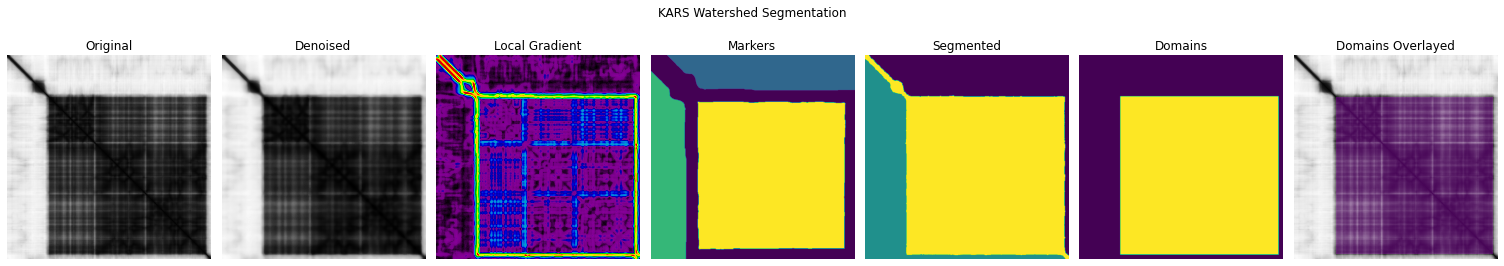

[1 2 3] labels
[0 3] domains


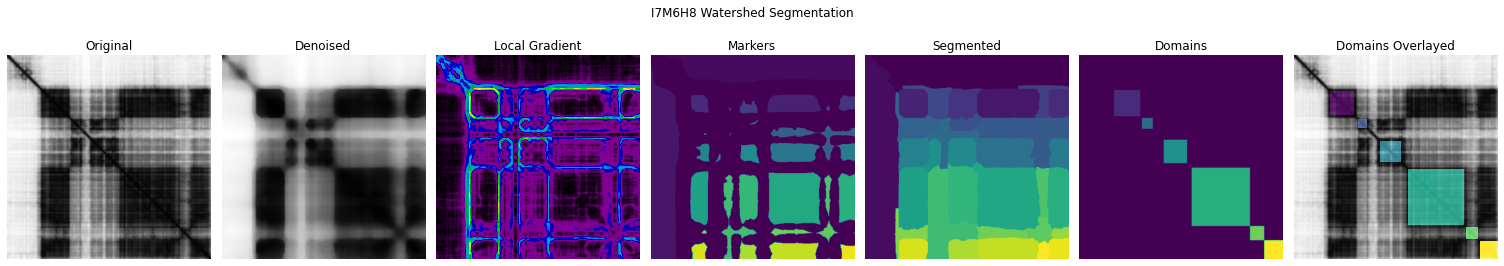

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] labels
[ 0  4 11 16 20 25 32] domains


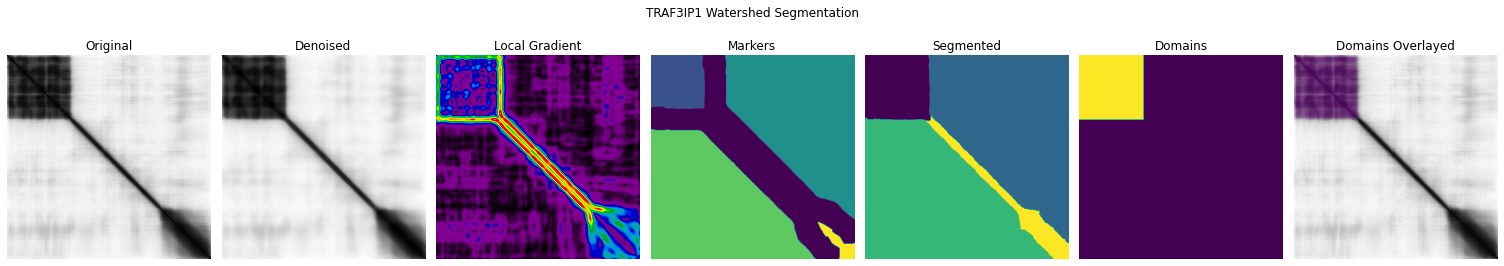

[1 2 3 4] labels
[0 1] domains


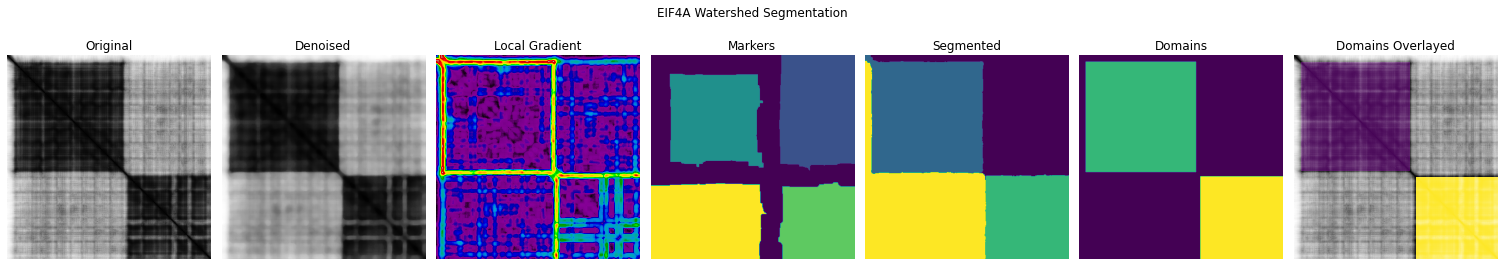

[1 2 3 4] labels
[0 2 3] domains


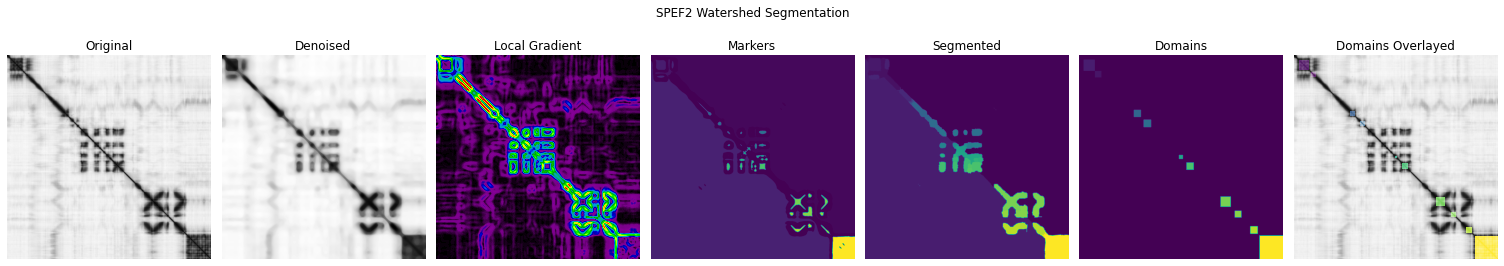

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88] labels
[ 0  5  7 29 32 53 63 70 72 78 88] domains


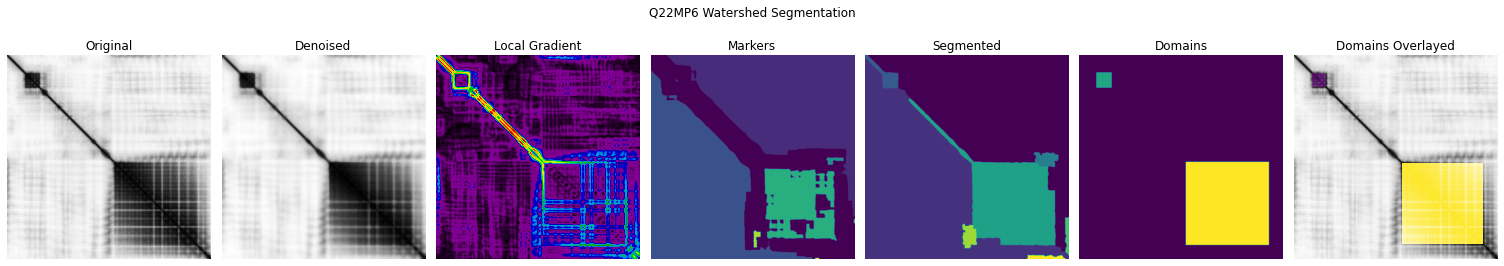

[1 2 3 4 5 6 7 8] labels
[0 3 5] domains


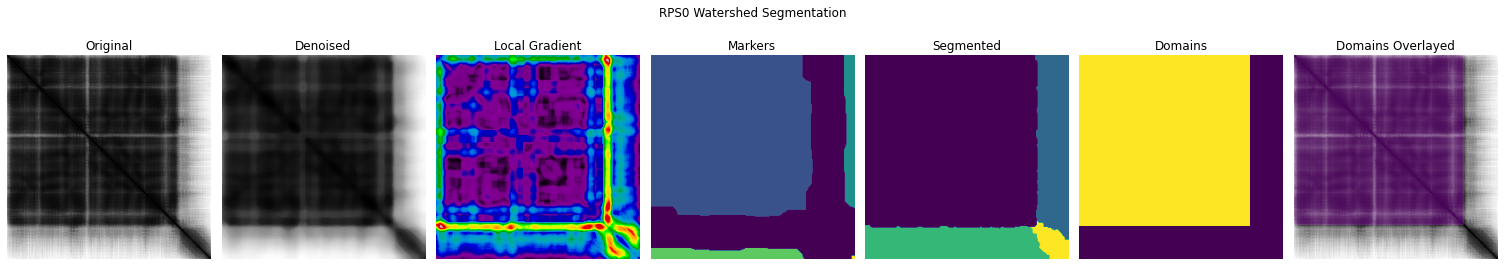

[1 2 3 4] labels
[0 1] domains


In [62]:
pae_proteins = [
    ("PRKG1", 12, 43, 115, 10, 1),
    ("EEF2", 20, 30, 20, 8, 5),
    ("MRNC57", 15, 50, 110, 10, 2),
    ("I7MJ59", 10, 50, 140, 10, 1),
    ("FTT18", 10, 10, 90, 4, 1),
    ("BBC118", 10, 50, 150, 10, 1),
    ("Q23A15", 10, 50, 150, 10, 1),
    ("KARS", 10, 45, 150, 10, 1),
    ("I7M6H8", 30, 35, 55, 5, 1),
    ("TRAF3IP1", 10, 50, 150, 10, 1),
    ("EIF4A", 10, 50, 150, 10, 1),
    ("SPEF2", 20, 20, 40, 20, 5),
    ("Q22MP6", 15, 60, 95, 10, 1),
    ("RPS0", 10, 50, 150, 10, 1)
]

labels = predict_watershed_for_proteins(pae_proteins)